<a href="https://colab.research.google.com/github/KBE25/pneumonia_diagnosis/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

# Data Understanding

## Data Preparation

In [1]:
#Load programs needed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img
import kagglehub

In [2]:
# Download latest dataset version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Identify the path for the dataset
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
# Define main data directories based on the Colab path
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

# List the subdirectories to confirm the classes available within the data
print("Training data classes:", os.listdir(train_dir))
print("Testing data classes:", os.listdir(test_dir))
print("Validation data classes:", os.listdir(val_dir))


Training data classes: ['PNEUMONIA', 'NORMAL']
Testing data classes: ['PNEUMONIA', 'NORMAL']
Validation data classes: ['PNEUMONIA', 'NORMAL']


## Exploratory Data Analysis


###1. Class Distribution:###

The next step will allow us to see how many images we have in each class ('NORMAL' and 'PNEUMONIA') within the training, test and validation datasets.
This step is important to complete as class imbalances can significanyly affect the model training.


In [4]:
# Function to plot the distribution of 'NORMAL' and 'PNEUMONIA' classes within a specified data directory
def plot_class_distribution(data_dir, title):
  """
    This definition visualizes and prints the number of images belonging to the 'NORMAL' and 'PNEUMONIA' classes within a given directory

    Arguments:
        data_dir (str): The path to the directory containing subdirectories named 'NORMAL' and 'PNEUMONIA'
        title (str): The title to be displayed on the plot and in the print output
    """

  # Construct the paths to the 'NORMAL' and 'PNEUMONIA' subdirectories and count the number of files (images) in each subdirectory
  normal_count = len(os.listdir(os.path.join(data_dir, 'NORMAL')))
  pneumonia_count = len(os.listdir(os.path.join(data_dir, 'PNEUMONIA')))

  # Store the counts and corresponding labels for plotting
  counts = [normal_count, pneumonia_count]
  labels = ['NORMAL', 'PNEUMONIA']

  # Create a figure and axes for the bar plot
  plt.figure(figsize=(8, 6))
  sns.barplot(x=labels, y=counts)
  # Set the title of the plot
  plt.title(f'Class Distribution in {title} Set')
  # Label the y-axis
  plt.ylabel('Number of Images')
  plt.show()

  # Print the class counts for the specified dataset
  print(f"{title} Set: NORMAL - {normal_count}, PNEUMONIA - {pneumonia_count}")


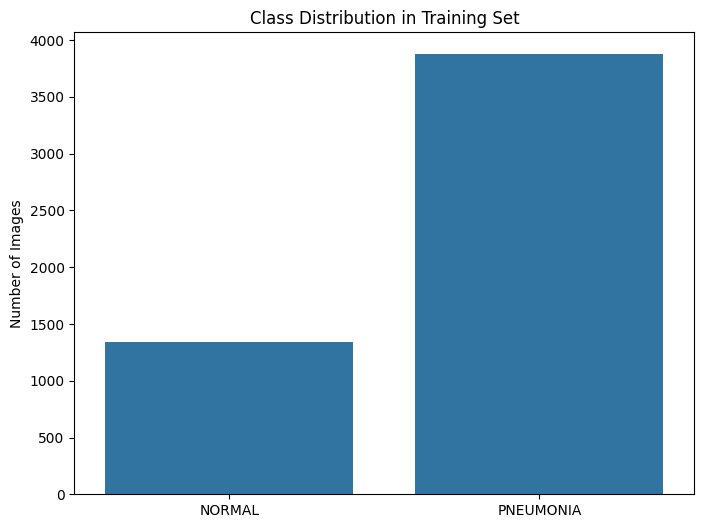

Training Set: NORMAL - 1341, PNEUMONIA - 3875


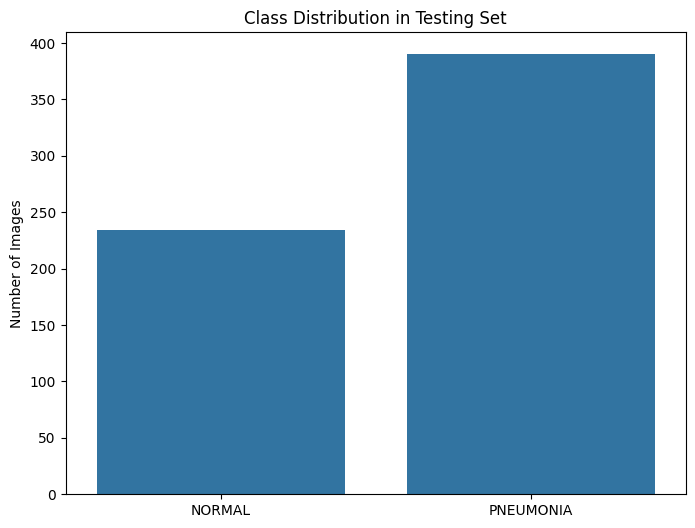

Testing Set: NORMAL - 234, PNEUMONIA - 390


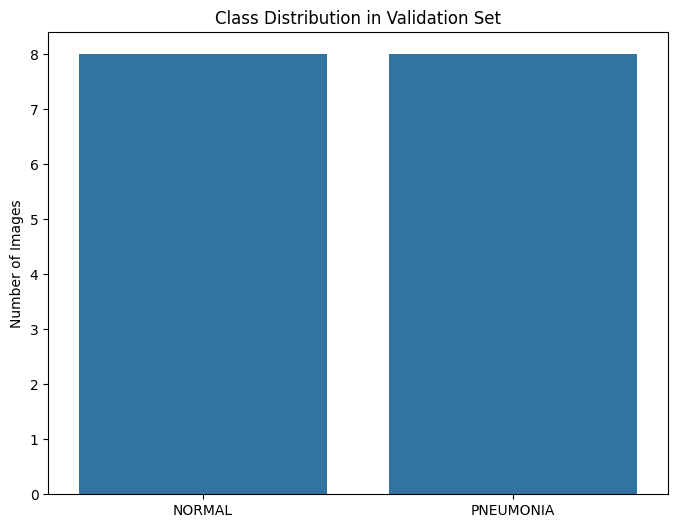

Validation Set: NORMAL - 8, PNEUMONIA - 8


In [5]:
# Call the function to visualize the class distribution for each dataset.
plot_class_distribution(train_dir, 'Training')
plot_class_distribution(test_dir, 'Testing')
plot_class_distribution(val_dir, 'Validation')

###2. Sample Images###

We are going to create a function so we can visualize a sample of the images from each class to get a sense of how the data looks like.

In [6]:
# Function to plot a sample of 5 images from each class ('NORMAL' and 'PNEUMONIA') within a specified data directory
def plot_sample_images(data_dir, title):
    """
    Displays a grid of sample images, showing 5 examples of 'NORMAL' and 5 examples of 'PNEUMONIA' images from the given directory

    Arguments:
        data_dir (str): The path to the directory containing subdirectories named 'NORMAL' and 'PNEUMONIA'
        title (str): The title to be displayed above the grid of images
    """
    # Get a list of the first 5 filenames from the 'NORMAL' subdirectory
    normal_files = os.listdir(os.path.join(data_dir, 'NORMAL'))[:5]
    # Get a list of the first 5 filenames from the 'PNEUMONIA' subdirectory
    pneumonia_files = os.listdir(os.path.join(data_dir, 'PNEUMONIA'))[:5]

    # Create a figure and a grid of subplots to display the images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    # Set the title for the entire figure.
    fig.suptitle(f'Sample Images from {title} Set', fontsize=16)

    # Loop through the first 5 'NORMAL' filenames along with their index.
    for i, file in enumerate(normal_files):
        # Construct the full path to the current 'NORMAL' image file
        img_path = os.path.join(data_dir, 'NORMAL', file)
        # Open the image using PIL library
        img = Image.open(img_path)
        # Display the opened image in the i-th column of the first row of subplots
        axes[0, i].imshow(img, cmap='gray')
        # Set the title of the current subplot to 'NORMAL'
        axes[0, i].set_title('NORMAL')
        # Turn off the axis labels and ticks for the current subplot for a cleaner look
        axes[0, i].axis('off')

    # Loop through the first 5 'PNEUMONIA' filenames along with their index
    for i, file in enumerate(pneumonia_files):
        # Construct the full path to the current 'PNEUMONIA' image file
        img_path = os.path.join(data_dir, 'PNEUMONIA', file)
        # Open the image using PIL library
        img = Image.open(img_path)
        # Display the opened image in the i-th column of the second row of subplots
        axes[1, i].imshow(img, cmap='gray')
        # Set the title of the current subplot to 'PNEUMONIA'
        axes[1, i].set_title('PNEUMONIA')
        # Turn off the axis labels and ticks for the current subplot for a cleaner look
        axes[1, i].axis('off')

    # Adjust the layout of the subplots to prevent titles from overlapping.
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

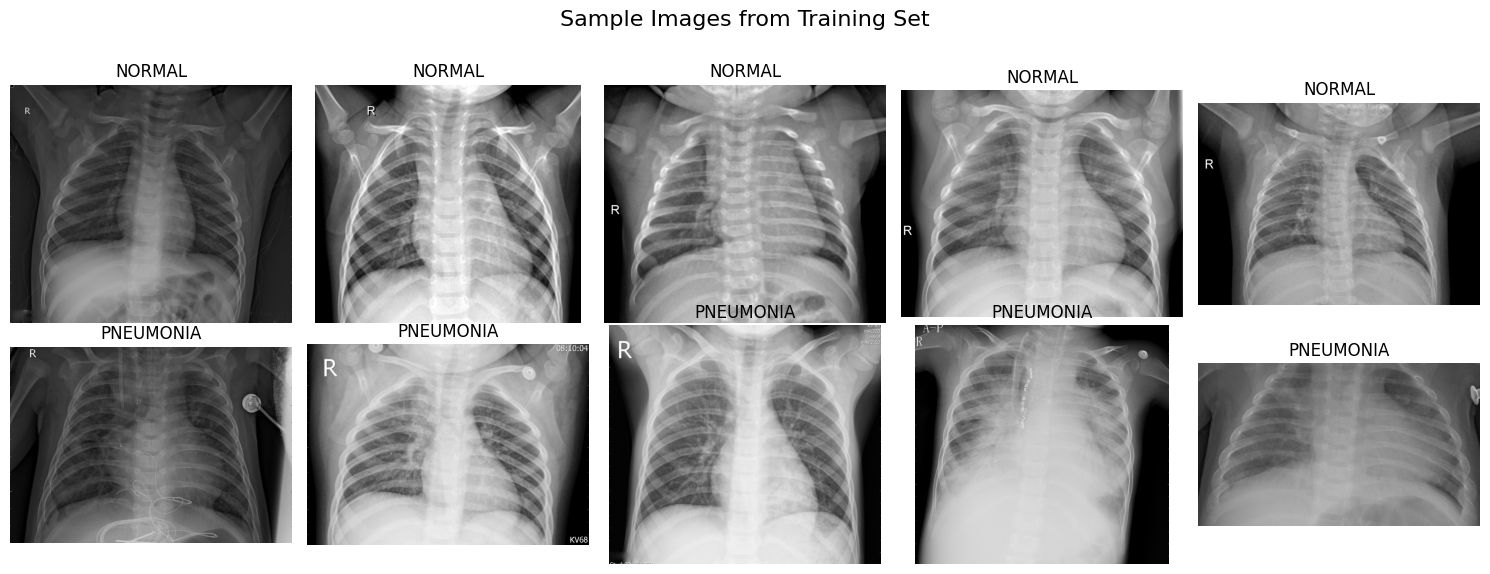

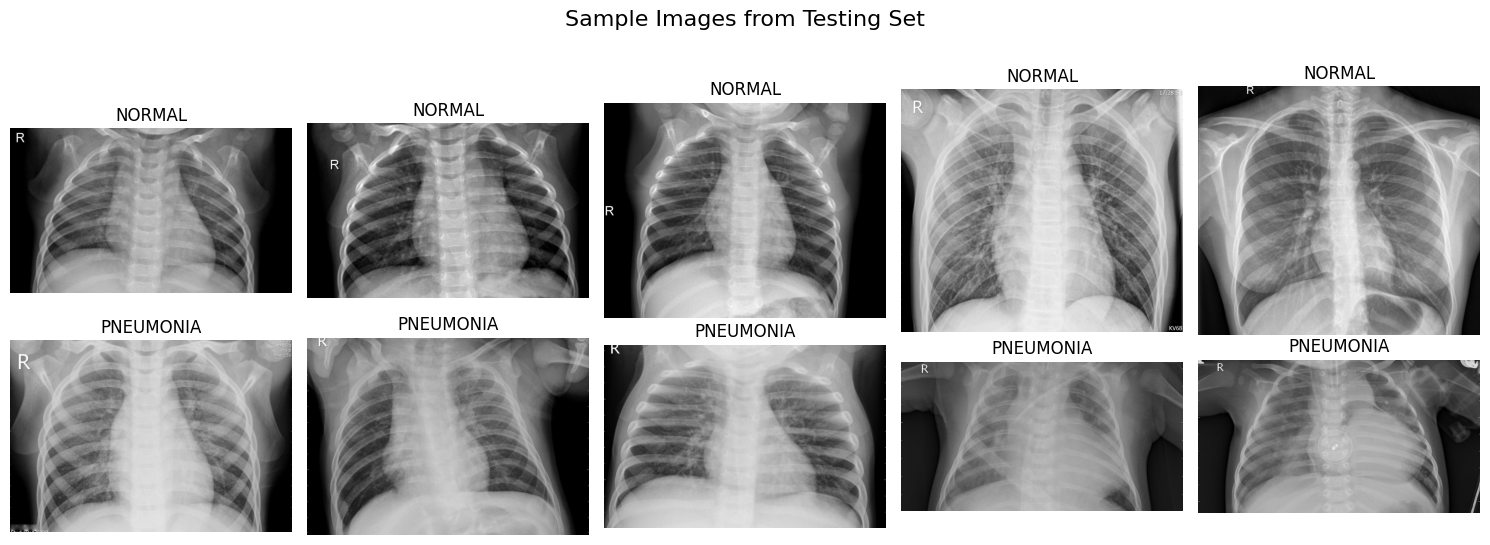

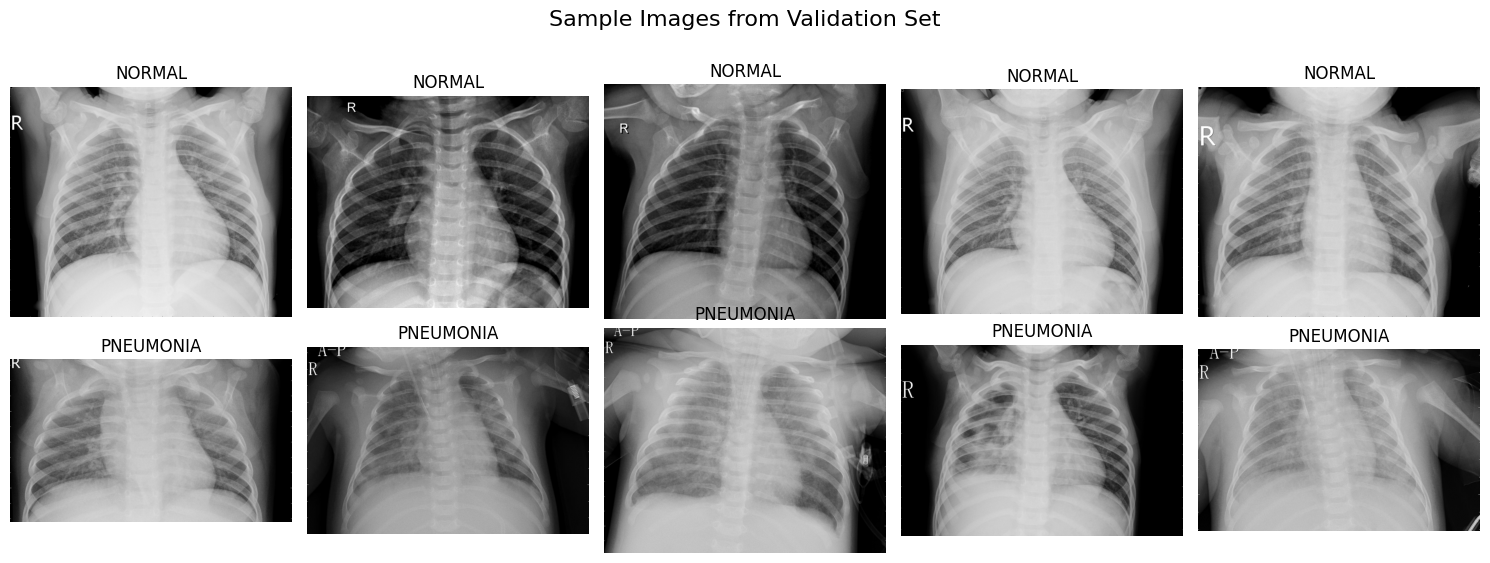

In [7]:
# Call the function to visualize sample images from each dataset
plot_sample_images(train_dir, 'Training')
plot_sample_images(test_dir, 'Testing')
plot_sample_images(val_dir, 'Validation')

###3. Image Size Analysis:###

When using a Neural Network, the model will expect the images to be of consistent square size. Per the above samples, the images size do not seem to be consistent so we are are going so we are now going to analyze the dimensions of the images in my dataset.

In [8]:
# Function to analyze the width and height of images in 'NORMAL' and 'PNEUMONIA'
def analyze_image_sizes(data_dir, title):
    """
    Analyzes the dimensions (width and height) of all images within the 'NORMAL' and 'PNEUMONIA' subdirectories
    It calculates and prints the average, maximum, and minimum width and height

    Arguments:
        data_dir (str): The path to the directory containing 'NORMAL' and 'PNEUMONIA' subdirectories with image files
        title (str): A descriptive title for the dataset being analyzed (e.g., 'Training', 'Validation', 'Testing').
    """
    widths = []  # Create an empty list to store image widths
    heights = [] # Create an empty list to store image heights

    # Iterate through the two class labels: 'NORMAL' and 'PNEUMONIA'
    for label in ['NORMAL', 'PNEUMONIA']:
        # Indicate the path to the directory containing images of the current class
        label_dir = os.path.join(data_dir, label)
        # Iterate through each file in the current class directory
        for file in os.listdir(label_dir):
            try:
                # Construct the full path to the image file
                img_path = os.path.join(label_dir, file)
                # Open the image using PIL library
                img = Image.open(img_path)
                # Get the width and height of the opened image
                width, height = img.size
                # Append the width and height to the empty lists created
                widths.append(width)
                heights.append(height)
            except Exception as e:
                # If an error occurs while processing an image (e.g., corrupted file), print an error message with the file path and the specific error
                print(f"Error processing {img_path}: {e}")

    # After processing all images, print the analysis results for the current dataset
    print(f"\nImage Size Analysis for {title} Set:")
    print(f"  Average Width: {np.mean(widths):.2f}, Max Width: {np.max(widths)}, Min Width: {np.min(widths)}")
    print(f"  Average Height: {np.mean(heights):.2f}, Max Height: {np.max(heights)}, Min Height: {np.min(heights)}")

    # Return the lists
    return widths, heights

In [9]:
# Call the function to analyze image sizes for each dataset
train_widths, train_heights = analyze_image_sizes(train_dir, 'Training')
val_widths, val_heights = analyze_image_sizes(val_dir, 'Validation')
test_widths, test_heights = analyze_image_sizes(test_dir, 'Testing')


Image Size Analysis for Training Set:
  Average Width: 1320.61, Max Width: 2916, Min Width: 384
  Average Height: 968.07, Max Height: 2663, Min Height: 127

Image Size Analysis for Validation Set:
  Average Width: 1348.25, Max Width: 1776, Min Width: 968
  Average Height: 1002.94, Max Height: 1416, Min Height: 592

Image Size Analysis for Testing Set:
  Average Width: 1388.13, Max Width: 2752, Min Width: 728
  Average Height: 991.71, Max Height: 2713, Min Height: 344


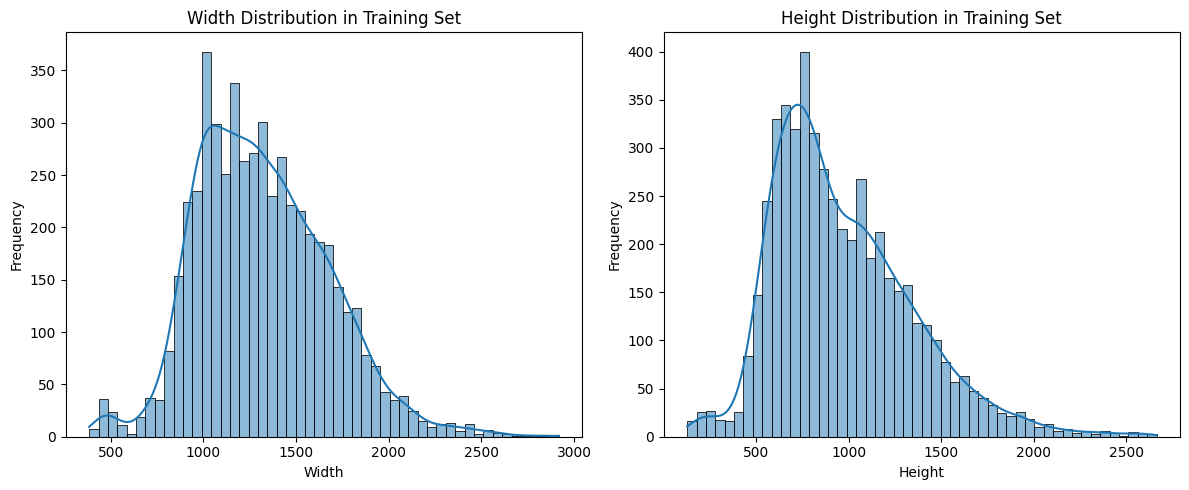

In [10]:
# Create a figure with two subplots for width and height distributions
plt.figure(figsize=(12, 5))

# First subplot for the distribution of image widths using an histogram plot
plt.subplot(1, 2, 1)
sns.histplot(train_widths, bins=50, kde=True)
# Title of the first subplot
plt.title(f'Width Distribution in Training Set')
# Label the x-axis and the y-axis of the first subplot.
plt.xlabel('Width')
plt.ylabel('Frequency')

# Second subplot for the distribution of image heights using an histogram plot
plt.subplot(1, 2, 2)
sns.histplot(train_heights, bins=50, kde=True)
# Set the title of the second subplot
plt.title(f'Height Distribution in Training Set')
# Label the x-axis and the y-axis of the second subplot.
plt.xlabel('Height')
plt.ylabel('Frequency')

# Adjust the spacing between subplots to prevent overlapping.
plt.tight_layout()
plt.show()


Per the histograms for the width and height of the images in the training set we can learn the following:


*   There is a wide range of dimensions for both the width and the height. The width ranges from roughtly 400-3000 pixels while the height ranges from about 300-2500 pixels which means that the images are not consistently sized.

*   Skewed distribution to the right which means that there more images with smaller to medium dimenstions, there is still a significant number of images that are considerable wider and taller. The presence of very large images can lead to inefficiencies as these can lead to increase computational cost and memory during model training.

*   The most typical dimensions within the trainign set range between 1000-1500 pixels for widdth and 800-1200 pixels for heights.

Based on the information in the histogram we might need to resize the images as Neuro Networks perform best with consisten input sizes.




Need for Resizing: The inconsistency in image sizes necessitates a resizing step as part of your preprocessing pipeline for your CNN. CNNs generally perform best with consistent input sizes.
Informing Resizing Strategy: The histograms can guide your decision on the target size for resizing. You might consider a size around the peaks to minimize distortion for the majority of images, but you also need to be mindful of potentially losing information from the larger images if you downsize too aggressively.
Potential for Aspect Ratio Issues: The different distributions of width and height suggest that the images likely have varying aspect ratios. Forcing them into a square shape during resizing might introduce distortion. You might need to consider resizing while preserving aspect ratio and then padding or cropping.
In short, the histograms reveal a dataset with significant variability in image dimensions, with a skew towards larger sizes. This highlights the necessity of a consistent resizing strategy for your CNN and provides insights into choosing an appropriate target size to balance information retention with computational efficiency.


(2) Could you give me a summary of why decreasing the image size can help the model?

Decreasing the image size for your CNN can be beneficial for the following key reasons:

- Faster Computation: Smaller images contain fewer pixels, leading to a significant reduction in the number of calculations required during the model's forward and backward passes. This results in faster training times and quicker experimentation.
- Reduced Memory Footprint: Smaller images consume less memory. This allows you to use larger batch sizes during training (which can improve gradient estimation and potentially lead to faster convergence) and makes it easier to train and deploy models on hardware with limited memory resources (like GPUs).
- Potentially Less Overfitting: By reducing the dimensionality of the input data, you can sometimes reduce the risk of overfitting, especially if fine, high-resolution details are not essential for the classification task. The model is forced to learn more general and robust features.
- Focus on Key Features: Downsizing can encourage the model to focus on the more salient, lower-frequency features that are often crucial for object recognition, rather than getting distracted by fine-grained noise or less important details present in high-resolution images.
- Feasibility: For very large datasets or limited computational resources, working with smaller images might be the only feasible way to train a complex CNN model within a reasonable timeframe.

In essence, decreasing image size often provides a better trade-off between computational efficiency, memory usage, and potentially model generalization, especially when the core diagnostic information is preserved at a lower resolution. However, it's crucial to find the right balance, as excessive downsampling can lead to information loss and decreased performance if important details are lost. Experimentation with different target sizes is key to finding the optimal dimensions for your specific task and dataset.-


(1) Should the image size reduction be applied only to the training dataset or all datasets (training, validation, and testing)?

You should apply the same image size reduction to all of your datasets: training, validation, and testing. Here's why:

- Consistency is Key: Your CNN learns patterns and features from the input size

of the images in the training set. During validation and testing, the model expects input data with the same characteristics it was trained on, including the image dimensions. If you train on smaller images but provide the original, larger images during validation or testing, the model might not perform as expected because the input distribution has changed.
- Realistic Evaluation: The purpose of the validation and testing sets is to evaluate how well your model generalizes to unseen data. If you process these datasets differently (e.g., by not resizing them), the performance metrics you obtain might not accurately reflect how the model would perform on real-world, unseen data that would likely undergo the same preprocessing steps.
- Deployment Consistency: When you deploy your trained model, it will expect images of a specific size. Preprocessing all your datasets consistently ensures that the model receives the expected input format throughout the entire workflow, from training to evaluation to deployment.

Therefore, the standard practice is to determine your target image size based on experimentation (often done by monitoring validation performance during training with different resized dimensions) and then apply that same resizing transformation to your training, validation, and testing datasets.

In [10]:
# Calculating the aspect ratios for the width and height for each image in the training dataset
aspect_ratios_train = np.array(train_widths) / np.array(train_heights)

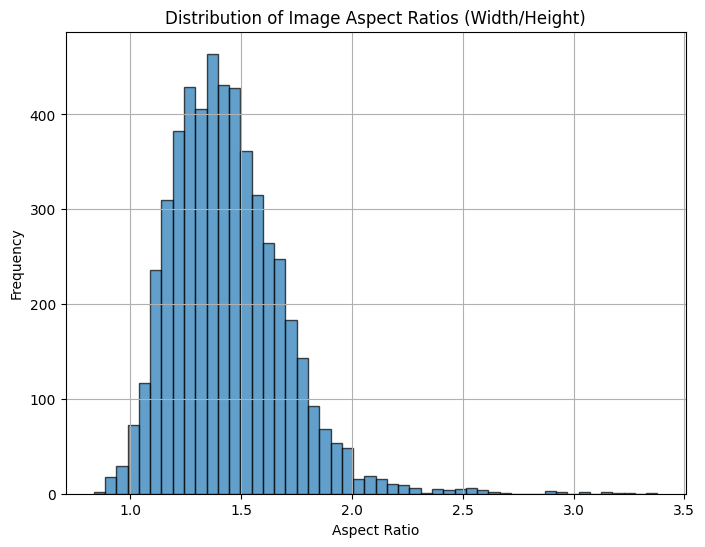

In [11]:
# Create a histogram to analyze the aspect ratios for the training data
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios_train, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Image Aspect Ratios (Width/Height)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
# Add a grid to the plot for better readability
plt.grid(True)
plt.show()

In [12]:
# Calculate median, standard deviation and percentiles for aspect ratios
print(f"\nMedian Aspect Ratio: {np.median(aspect_ratios_train):.2f}")
print(f"Standard Deviation of Aspect Ratio: {np.std(aspect_ratios_train):.2f}")
print(f"Aspect Ratio Percentiles (25th, 50th, 75th): {np.percentile(aspect_ratios_train, [25, 50, 75])}")

# Calculate Percentiles for Widths and Heights
print("\nWidth Percentiles (25th, 50th, 75th):")
print(np.percentile(train_widths, [25, 50, 75]))

print("\nHeight Percentiles (25th, 50th, 75th):")
print(np.percentile(train_heights, [25, 50, 75]))


Median Aspect Ratio: 1.41
Standard Deviation of Aspect Ratio: 0.26
Aspect Ratio Percentiles (25th, 50th, 75th): [1.25747021 1.41170132 1.58341837]

Width Percentiles (25th, 50th, 75th):
[1056. 1284. 1552.]

Height Percentiles (25th, 50th, 75th):
[ 688.    888.   1187.75]


Based on the above information we will test the following sizing options [TO
 ADD OPTIONS] before completing the padding or cropping.
  1.define functions for loading images, cripping and padding



  Okay, let's summarize the rationale behind considering 256x256 and 512x512 as potential image resizing targets based on your provided histograms:

Why consider 256x256?

Better Detail Retention than 300x300: While still downsampling from the original larger image sizes (which peak around 1200-1500 width and 1000-1300 height), 256x256 is closer to these peaks than 300x300 in at least one dimension. This means it's likely to retain more of the original image information and potentially crucial visual features relevant for pneumonia detection.
Computational Efficiency: 256x256 is a common size in image processing and deep learning. It strikes a good balance between retaining detail and maintaining reasonable computational cost (memory usage, training time). It's a power of 2, which can sometimes be beneficial for certain neural network architectures and operations.
Common Standard: Many pre-trained models and research papers use input sizes around this range, making it a reasonable starting point for experimentation and potential transfer learning.
Why consider 512x512?

Greater Detail Retention: 512x512 is significantly larger than 300x300 and 256x256. By resizing to this size, you preserve even more of the original image's details. This could be particularly important if subtle visual cues are critical for accurately distinguishing between normal and pneumonia cases in the chest X-rays.
Potential for Higher Accuracy (at a cost): With more information retained, there's a possibility that your model could learn more complex patterns and achieve higher accuracy.
Addressing Significant Downsampling: Given that many of your original images have dimensions well above 512 pixels in both width and height, resizing to 512x512 still involves downsampling but is less aggressive than going to 300x300.
In essence:

256x256 offers a compromise: It aims to retain more information than your initial 300x300 while keeping computational costs manageable.
512x512 prioritizes detail retention: It aims to preserve as much original information as feasible, potentially leading to better performance if the extra detail is important, but at the expense of higher computational resources.
The histograms suggest that the original images have considerable resolution. Downsampling too much might discard valuable information. Therefore, experimenting with these larger sizes is a logical step to see if preserving more of the original image detail translates to improved model performance. You'll need to empirically evaluate the performance of your model with these different target_size values to determine which one works best for your specific dataset and model architecture.

In [16]:
# Create an ImageDataGenerator for the training data
# This generator will handle rescaling and splitting the training data into training and validation sets
# rescale: normalize pixel values to the range [0, 1]
# validation_split: reserve 25% of the training data for validation
training_generator = ImageDataGenerator(rescale=1/255, validation_split=0.25)

# Create an ImageDataGenerator for the test data
# We only need to rescale the test data, no validation split is needed
test_generator = ImageDataGenerator(rescale=1/255)

# Create a data generator for the training set
# It reads images from the 'train_dir', resizes them, converts to grayscale,
# assigns binary labels based on subdirectory names, shuffles the data, and yields batches
train_set = training_generator.flow_from_directory(
    train_dir,
    target_size=(256, 256),   # Resize all images to 256x256 pixels
    batch_size=32,             # Process images in batches of 32
    color_mode='grayscale',    # Convert images to grayscale (single channel)
    class_mode='binary',       # Assume subdirectories contain two classes (e.g., 'NORMAL' and 'PNEUMONIA')
    seed=42,                   # Set a random seed for reproducibility
    subset='training'          # Specify that this generator is for the training subset
)

# Create a data generator for the validation set
# It reads images from the 'train_dir' (the original training directory), resizes them,
# converts to grayscale, assigns binary labels, and yields batches from the validation split
val_set = training_generator.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    seed=42,
    subset='validation'        # Specify that this generator is for the validation subset
)

# Create a data generator for the test set
# It reads images from the 'test_data_dir', resizes them, converts to grayscale,
# assigns binary labels, and yields batches. No subset is specified as it's the entire test set.
test_set = test_generator.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary'
)

# Create the datasets
train_images, train_labels = next(train_set)
val_images, val_labels = next(val_set)
test_images, test_labels = next(test_set)

Found 3913 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
# Print the shapes of the image batches
print("Shape of training images:", train_images.shape)
print("Shape of validation images:", val_images.shape)
print("Shape of test images:", test_images.shape)

# If you also want to see the shape of the labels:
print("Shape of training labels:", train_labels.shape)
print("Shape of validation labels:", val_labels.shape)
print("Shape of test labels:", test_labels.shape)

Shape of training images: (32, 256, 256, 1)
Shape of validation images: (32, 256, 256, 1)
Shape of test images: (32, 256, 256, 1)
Shape of training labels: (32,)
Shape of validation labels: (32,)
Shape of test labels: (32,)


### Data Augmentation

Data augmentation


Note: We don't typically augment the validation or test sets.
The test_generator_no_aug is already defined for the test set.

Vertical flipping alone is likely a minimal augmentation, and whether it's "enough" to test depends heavily on the characteristics of your chest X-ray dataset and the potential biases within it.

Here's a breakdown of why it's minimal and points to consider regarding its sufficiency:

Why Vertical Flip is Minimal:

Limited Transformation: Vertical flipping is a relatively simple geometric transformation. It doesn't introduce new features or significantly alter the underlying visual information in the way that rotations, zooms, or changes in brightness/contrast do.
Symmetry Considerations: For many objects, including internal organs like those visible in a chest X-ray, there might be a degree of inherent symmetry. A vertical flip might result in an image that is still biologically plausible.
Is it "Enough" to Test?

Testing for Specific Biases: Vertical flipping can be useful for testing if your model has learned any biases related to the vertical orientation of features in your training data. For example, if all pneumonia cases happen to be oriented in a certain way due to image acquisition practices, vertical flipping could help the model become more robust to variations in orientation.
Minimal Baseline: It's a good starting point for a minimal augmentation baseline. If even this simple augmentation provides a noticeable improvement, it suggests that the model might be sensitive to orientation.
Not Comprehensive: However, it's unlikely to be a comprehensive test of the benefits of data augmentation in general. Many other types of augmentations (rotation, translation, scaling, brightness/contrast adjustments, etc.) can help the model generalize better to a wider range of real-world variations in image appearance.
Risk of Overwhelming the Model with Synthetic Information:

Low Risk with Vertical Flip: Vertical flipping is unlikely to overwhelm the model with unrealistic synthetic information, especially for medical images where the flipped version might still represent a plausible anatomical configuration. The changes are not drastic.
To get a more robust understanding of the benefits of data augmentation, you should ideally experiment with a wider range of transformations. However, starting with a minimal augmentation like vertical flip is a sensible approach for the following reasons:

Isolate the Effect: It allows you to isolate the impact of a single, simple transformation.
Computational Cost: Minimal augmentations have a lower computational overhead during training compared to more complex augmentation pipelines.
Debugging: If you encounter issues with augmentation, starting with a simple one can make debugging easier.
Recommendations:

Start with your baseline (no augmentation). Get a clear understanding of its performance.
Implement the vertical flip augmentation as you've done. Train a separate model and compare its performance on the same validation and test sets as your baseline.
Consider adding other augmentations incrementally. Experiment with:
Horizontal Flip (horizontal_flip=True): Often very useful as left-right orientation shouldn't matter for most chest X-ray findings.
Small Rotations (rotation_range=10 or similar): Can help with slight variations in patient positioning.
Small Translations (width_shift_range=0.1, height_shift_range=0.1): Accounts for minor shifts in the image.
Small Zoom (zoom_range=0.1 or similar): Can help with slight variations in scale.
By gradually adding and evaluating different augmentations, you can determine which ones provide the most significant improvements for your specific task without overwhelming the model with unrealistic data.

In conclusion, vertical flip is a minimal and reasonable starting point for testing the impact of augmentation. However, for a more thorough evaluation of augmentation benefits and to build a truly robust model, exploring a wider range of transformations is recommended.

In [24]:
# Create an ImageDataGenerator for the training data WITH vertical flip
training_generator_aug = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.25,
    vertical_flip=True  # Add vertical flip for augmentation along the Y-axis
)


# Create data generators for the training and validation sets WITH Y-axis flip
train_set_aug = training_generator_aug.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    seed=42,
    subset='training'
)

val_set_aug = training_generator_aug.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    seed=42,
    subset='validation'
)

# Create the datasets WITH Y-axis flip augmentation
train_images_aug, train_labels_aug = next(train_set_aug)
val_images_aug, val_labels_aug = next(val_set_aug)

print("\nShape of training images (Y-axis flip augmentation):", train_images_aug.shape)
print("\nShape of training images (Y-axis flip augmentation):", train_labels_aug.shape)
print("Shape of validation images (Y-axis flip augmentation):", val_images_aug.shape)
print("Shape of validation images (Y-axis flip augmentation):", val_labels_aug.shape)


Found 3913 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.

Shape of training images (Y-axis flip augmentation): (32, 256, 256, 1)

Shape of training images (Y-axis flip augmentation): (32,)
Shape of validation images (Y-axis flip augmentation): (32, 256, 256, 1)
Shape of validation images (Y-axis flip augmentation): (32,)


# Exploratory Data Analysis

# Conclusions

## Limitations

## Recommendations

## Next Steps